In [1]:
import pickle
from misc import *
import SYCLOP_env as syc
from RL_brain_b import DeepQNetwork


In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
import cv2

In [4]:
from mnist import MNIST

mnist = MNIST('/home/bnapp/datasets/mnist/')
images, labels = mnist.load_training()

some_mnist =[ cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256), interpolation=cv2.INTER_AREA) for uu in images[:20]]           
some_mnistSM =[ cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256)) for uu in images[:5]]           
some_mnist0p5 =[ 0.5*cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256), interpolation=cv2.INTER_AREA) for uu in images[:20]]    
some_mnistSM0p5 =[ 0.5*cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256)) for uu in images[:20]]           


In [5]:
    hp = HP()
    hp.mem_depth=1
    hp.logmode = False
#     recorder = Recorder(n=4)
#     images = read_images_from_path('../video_datasets/liron_images/*.jpg')
#     images = [np.mean(1.0*uu, axis=2) for uu in images]
#     images = [cv2.resize(uu, dsize=(256, 256-64), interpolation=cv2.INTER_AREA) for uu in images]
#     images += read_images_from_path('/home/bnapp/arivkindNet/video_datasets/stills_from_videos/some100img_from20bn/*',max_image=10)
    images = some_mnistSM# +some_mnistSM0p5 # + some_mnist0p5 +some_mnistSM 
#     images = [np.sum(1.0*uu, axis=2) for uu in images]
#     images = [cv2.resize(uu, dsize=(256, 256-64), interpolation=cv2.INTER_AREA) for uu in images]
#     import pickle
#     with open('../video_datasets/liron_images/shuffled_images.pkl','rb') as f:
#         uu = pickle.load(f)
#     images +=uu
    scene = syc.Scene(frame_list=images)
    sensor = syc.Sensor()
    agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

    reward = syc.Rewards()
    observation_size = 256*4
    RL = DeepQNetwork(len(agent.hp.action_space), observation_size*hp.mem_depth,#sensor.frame_size+2,
                      reward_decay=0.99,
                      e_greedy=1-1e-7,
                      e_greedy0=1-1e-7,
                      replace_target_iter=10,
                      memory_size=100000,
                      e_greedy_increment=0.0001,
                      learning_rate=0.0025,
                      double_q=False,
                      dqn_mode=True,
                      state_table=np.zeros([1,observation_size*hp.mem_depth])
                      )




In [28]:
# RL.dqn.load_nwk_param('saed_runs/run_syclop_lirondb.py_noname_1557658952/best_liron.nwk')
# RL.dqn.load_nwk_param('saved_runs/old_flat_saves/liron_random_ic05.nwk')
# RL.dqn.load_nwk_param('saved_runs/run_syclop_generic1.py_noname_1559252614/tempX_1.nwk') #10M run
# RL.dqn.load_nwk_param('saved_runs/run_syclop_generic1.py_noname_1559252614/best_liron.nwk') #10M run bset
# RL.dqn.load_nwk_param('saved_runs/run_syclop_generic1.py_noname_1559836592/tempX_1.nwk')

# RL.dqn.load_nwk_param('saved_runs/run_syclop_generic1.py_noname_1563361626/tempX_1.nwk')
# RL.dqn.load_nwk_param('saved_runs/run_syclop_generic1.py_noname_156343334923587232/tempX_1.nwk')

# run_dirs = 'saved_runs/run_syclop_generic1.py_noname_156343334923587232/'
# run_dirs = 'saved_runs/run_syclop_generic1.py_noname_156343334923593472/'
run_dirs = 'saved_runs/run_syclop_generic1.py_noname_156343334923583712/'

# RL.dqn.load_nwk_param('saved_runs/run_syclop_generic1.py_noname_1559248534/tempX_1.nwk')
# RL.dqn.load_nwk_param('saved_runs/run_syclop_generic1.py_noname_1559122242/tempX_1.nwk')

In [29]:
result_type='best_liron.nwk' #'tempX_1.nwk'
RL.dqn.load_nwk_param(run_dirs+'/'+ result_type) #tempX_1.nwk')
with open(run_dirs+'/hp.pkl','rb') as f:
          this_hp = pickle.load(f)
          hp.fading_mem = this_hp.fading_mem +0.0 #to avoid assignment by address'

In [30]:

def local_observer(sensor,agent):
    if hp.logmode:
        normfactor=1.0
    else:
        normfactor = 1.0/256.0
    # return np.concatenate([1.0/65000*(sensor.dvs_view.reshape([-1]))])
    # return 1.0/65000*np.concatenate([relu_up_and_down(sensor.central_dvs_view),
    #        relu_up_and_down(sensor.dvs_view, downsample_fun=lambda x: cv2.resize(x, dsize=(16, 16), interpolation=cv2.INTER_AREA))])
    return normfactor*np.concatenate([relu_up_and_down(sensor.central_dvs_view),
            relu_up_and_down(cv2.resize(1.0*sensor.dvs_view, dsize=(16, 16), interpolation=cv2.INTER_AREA))])

observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
# hp.fading_mem = 0.5

In [31]:
recorders=[]
spike_records = []
for image_num,image in enumerate(images):
    recorder = Recorder(n=4)
    step = 0
    episode = 0
    observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
    observation_ = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
    scene.current_frame = image_num
    scene.image = scene.frame_list[scene.current_frame]

    agent.reset()
    agent.q_ana[1]=256./2.-32
    agent.q_ana[0]=256./2-32
    agent.q = np.int32(np.floor(agent.q_ana))
#     spikes =[[]]*5
    spikes =[[],[],[],[],[]]
    print(spikes)
    sensor.reset()
    sensor.update(scene, agent)
    sensor.update(scene, agent)
    for step_prime in range(1000):
#         action = RL.choose_action(observation.reshape([-1]))
        oo = RL.dqn.eval_incl_layers(observation.reshape([1,-1]))
        action=np.argmax(oo[0])
        action0 = RL.choose_action(observation.reshape([-1]))
        print(action,action0)
        for ii,uu in enumerate(oo[1:]):
#             print(ii,'debuA', np.shape(spikes[ii]))
            spikes[ii].append(uu.reshape([-1]).tolist())
#             print(ii,'debuB', np.shape(spikes[ii]))
#         print('-----------------------')
        reward.update_rewards(sensor = sensor, agent = agent)
        recorder.record([agent.q_ana[0],agent.q_ana[1],reward.reward,RL.epsilon])
        agent.act(action)
        sensor.update(scene,agent)
        observation *= hp.fading_mem
        observation += local_observer(sensor, agent)  # todo: generalize
        if step%1000 ==0:
            print(episode,step)
#                 print('frame:', scene.current_frame)
        step += 1
    recorders.append(recorder)
    spike_records.append(spikes)



[[], [], [], [], []]
7 7
0 0
7 7
7 7
4 4
4 4
4 4
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
8 8
6 6
6 6
6 6
6 6
6 6
6 6
5 5
6 6
7 7
7 7
5 5
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
8 8
8 8
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
7 7
4 4
4 4
4 4
4 4
6 6
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
7 7
7 7
4 4
4 4
4 4
4 4
4 4
7 7
6 6
7 7
6 6
6 6
7 7
7 7
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
7 7
7 7
4 4
8 8
7 7
6 6
8 8
8 8
7 7
4 4
4 4
4 4
4 4
4 4
4 4
7 7
6 6
4 4
6 6
6 6
6 6
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
6 6
6 6
6 6
6 6
7 7
7 7
4 4
7 7
7 7
7 7
7 7
8 8
8 8
8 8
4 4
6 6
6 6
6 6
6 6
5 5
5 5
6 6
4 4
4 4
4 4
4 4
1 1
7 7
7 7
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4

4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4


4 4
4 4
4 4
7 7
7 7
4 4
4 4
8 8
6 6
6 6
6 6
6 6
6 6
8 8
4 4
4 4
4 4
4 4
6 6
6 6
7 7
4 4
7 7
7 7
7 7
4 4
4 4
4 4
4 4
6 6
4 4
4 4
6 6
4 4
4 4
4 4
7 7
7 7
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
4 4
4 4
6 6
6 6
7 7
8 8
7 7
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
6 6
5 5
4 4
4 4
4 4
4 4
4 4
4 4
6 6
7 7
7 7
6 6
6 6
7 7
8 8
8 8
6 6
6 6
6 6
4 4
8 8
8 8
8 8
8 8
7 7
7 7
7 7
4 4
4 4
4 4
6 6
5 5
5 5
5 5
6 6
6 6
4 4
4 4
4 4
4 4
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
6 6
8 8
8 8
4 4
4 4
4 4
8 8
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
1 1
4 4
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
5 5
5 5
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
4 4
7 7
4 4
4 4
4 4
4 4
4 4
4 4


In [14]:
recorders=[]
for image_num,image in enumerate(images):
    recorder = Recorder(n=4)
    step = 0
    episode = 0
    observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
    observation_ = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
    scene.current_frame = image_num
    scene.image = scene.frame_list[scene.current_frame]

    agent.reset()
    agent.q_ana[1]=256./2.-32
    agent.q_ana[0]=256./2-32
    agent.q = np.int32(np.floor(agent.q_ana))
#     agent.q_ana[1]=256./2.-32
#     agent.q_ana[0]=192./2-32
#     agent.q = np.int32(np.floor(agent.q_ana))

    sensor.reset()
    sensor.update(scene, agent)
    sensor.update(scene, agent)
    for step_prime in range(1000):
        action = RL.choose_action(observation.reshape([-1]))
        oo = RL.dqn.eval_incl_layers(observation.reshape([1,-1]))
        action1=np.argmax(oo[0])
        print(action,action1)
        reward.update_rewards(sensor = sensor, agent = agent)
        recorder.record([agent.q_ana[0],agent.q_ana[1],reward.reward,RL.epsilon])
        agent.act(action)
        sensor.update(scene,agent)
        observation *= hp.fading_mem
        observation += local_observer(sensor, agent)  # todo: generalize
        if step%1000 ==0:
            print(episode,step)
#                 print('frame:', scene.current_frame)
        step += 1
    recorders.append(recorder)



6 6
0 0
6 6
6 6
6 6
6 6
7 7
6 6
6 6
4 4
6 6
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
4 4
7 7
4 4
4 4
4 4
4 4
4 4
7 7
4 4
7 7
7 7
7 7
6 6
7 7
7 7
6 6
6 6
7 7
5 5
7 7
7 7
4 4
4 4
4 4
4 4
2 2
5 5
6 6
6 6
6 6
6 6
8 8
6 6
6 6
6 6
6 6
5 5
6 6
6 6
6 6
6 6
6 6
4 4
4 4
6 6
4 4
6 6
7 7
7 7
4 4
4 4
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
5 5
7 7
7 7
4 4
4 4
7 7
4 4
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
4 4
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
7 7
7 7
8 8
8 8
7 7
7 7
7 7
7 7
8 8
6 6
6 6
6 6
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
7 7
4 4
4 4
7 7
7 7
7 7
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
4 4
7 7
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
4 4
4 4
6 6
6 6
7 7
5 5
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
6 6
6 6
6 6
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
6 6
6 6
2 2
2 2
4 4
7 7
7 7
7 7
7 7
7 7
7 7
7 7
5 5
7 7
7 7
4 4
4 4
7 7
6 6
4 4
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
6 6
6 6
4 4


4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
7 7
4 4
4 4
7 7
4 4
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
7 7
4 4
4 4
7 7
4 4
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
7 7
4 4
4 4
7 7
4 4
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
7 7
4 4
4 4
7 7
4 4
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
7 7
4 4
4 4
7 7
4 4
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
7 7
4 4
4 4
7 7
4 4
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
7 7
4 4
4 4
7 7
4 4
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
7 7
4 4
4 4
7 7
4 4
6 6
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
4 4
7 7
4 4
4 4
7 7
4 4
6 6
6 6
6 6
6 6
4 4
4 4


7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
6 6
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
6 6
4 4
4 4
4 4
4 4
4 4
4 4
4 4
7 7
7 7
7 7
7 7
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4


<IPython.core.display.Javascript object>


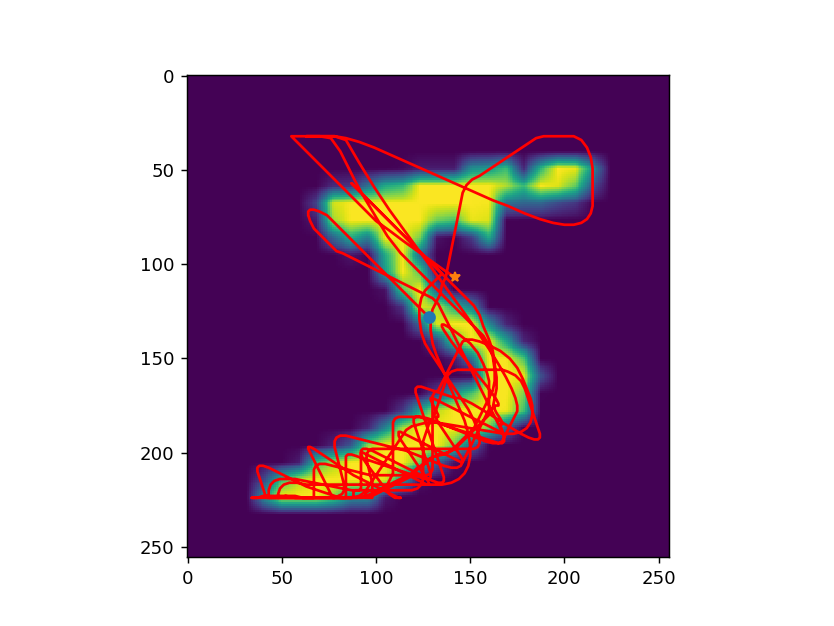

<IPython.core.display.Javascript object>


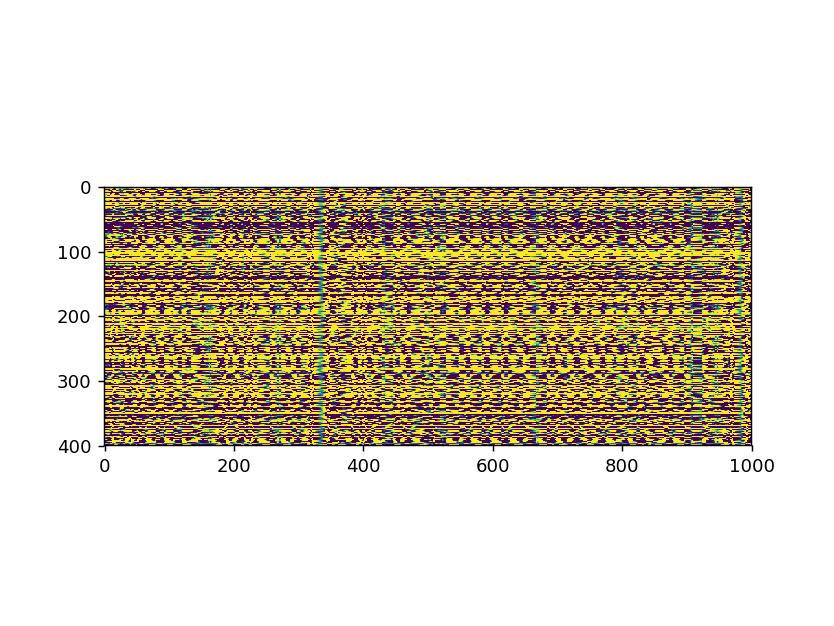

<IPython.core.display.Javascript object>


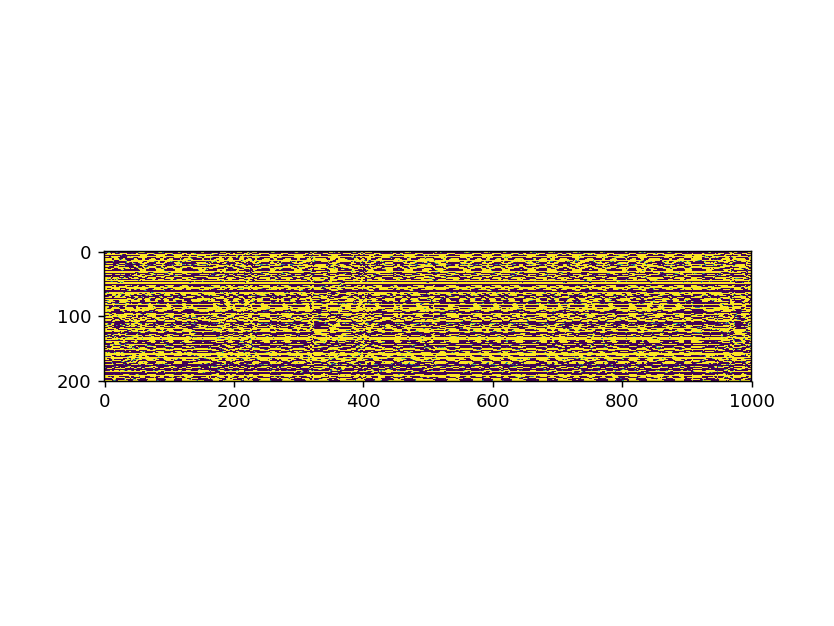

<IPython.core.display.Javascript object>


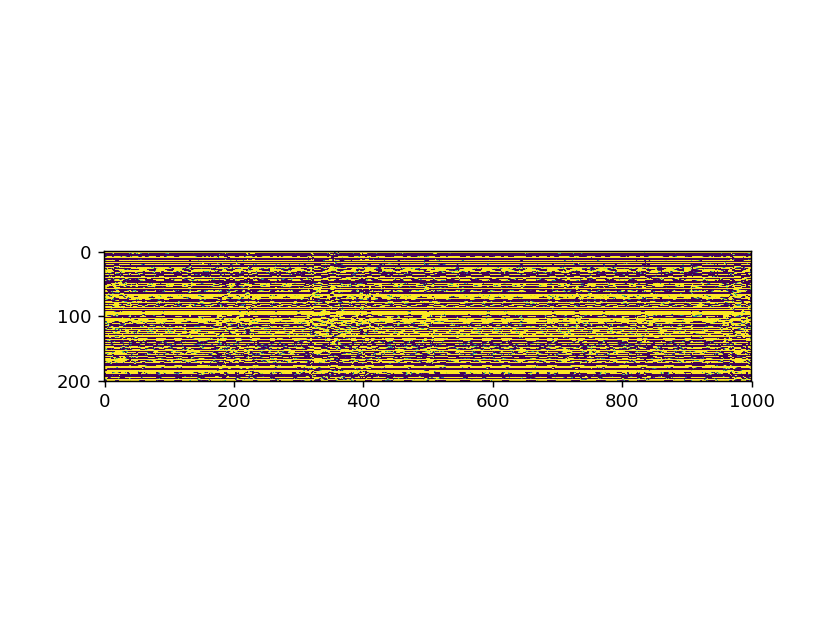

<IPython.core.display.Javascript object>


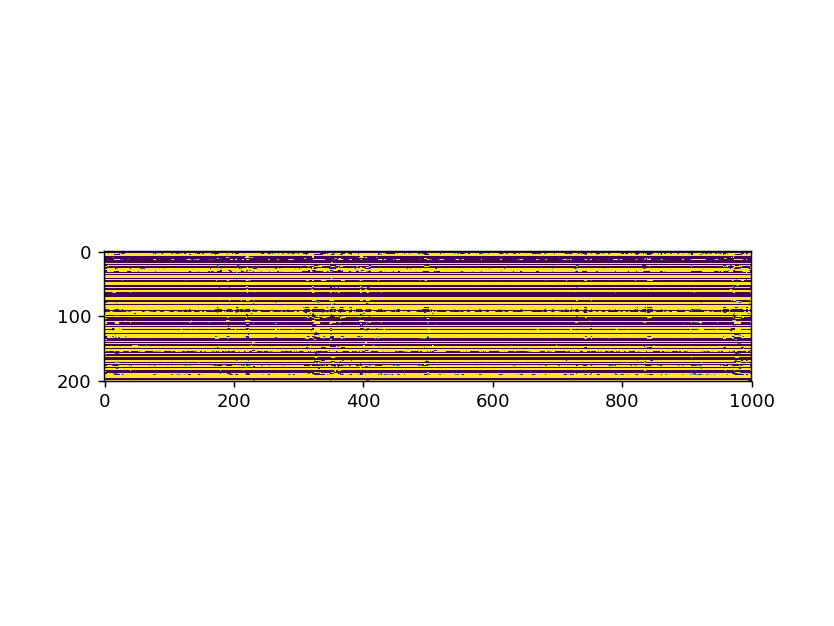

<IPython.core.display.Javascript object>


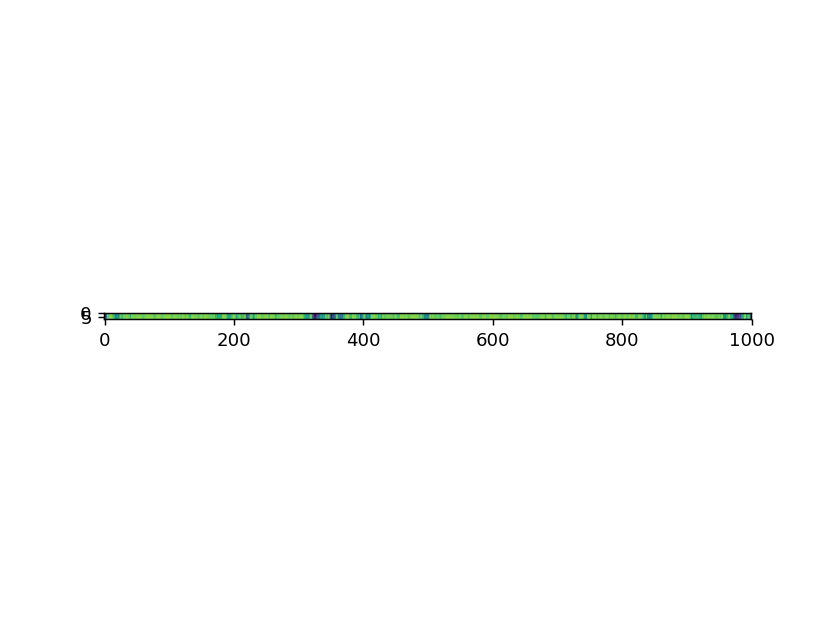

<IPython.core.display.Javascript object>


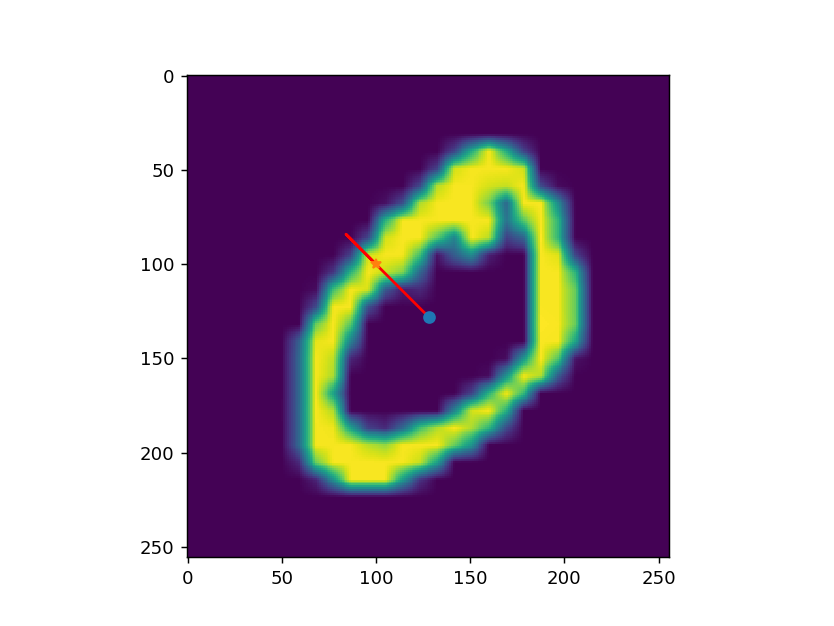

<IPython.core.display.Javascript object>


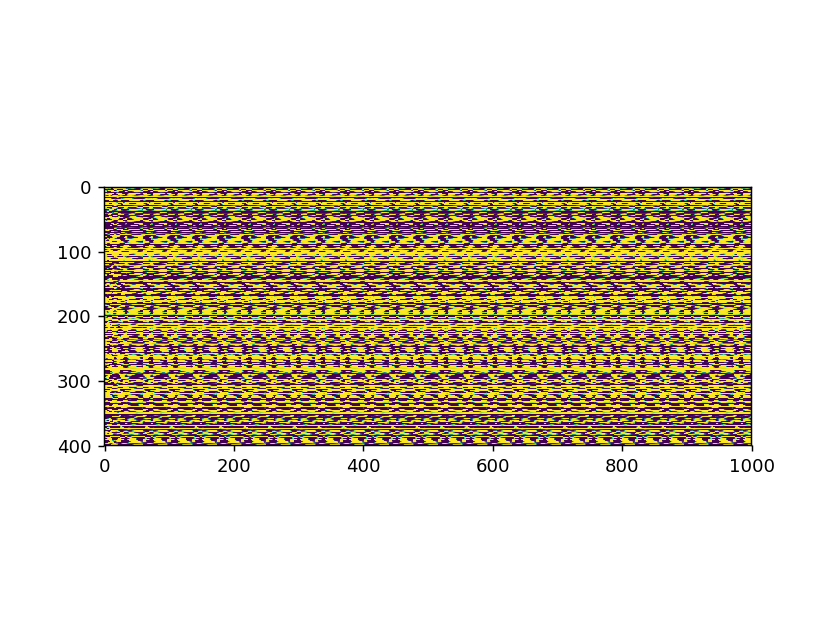

<IPython.core.display.Javascript object>


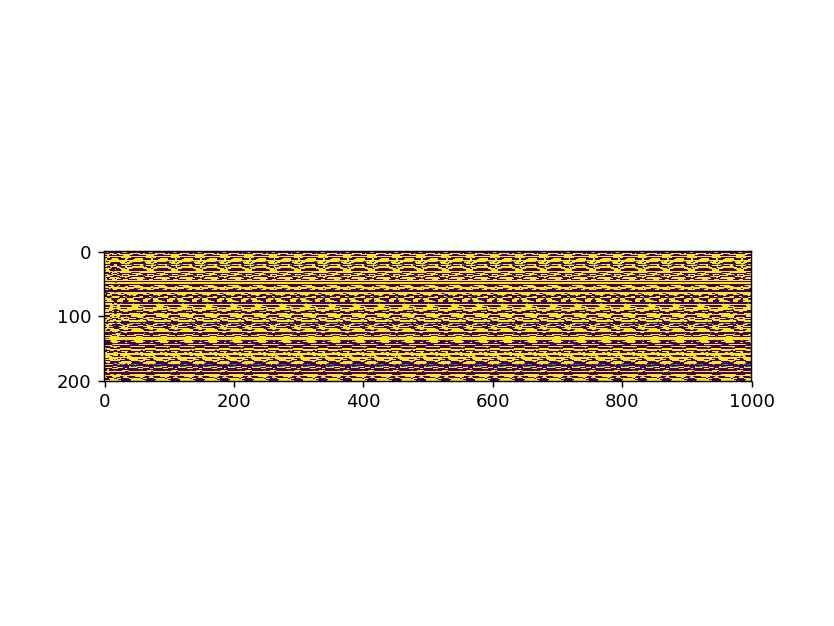

<IPython.core.display.Javascript object>


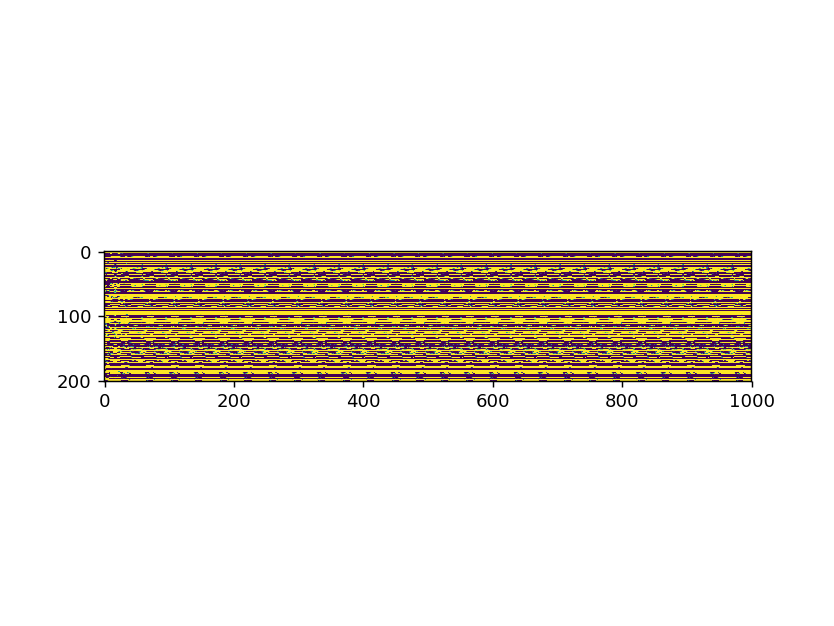

<IPython.core.display.Javascript object>


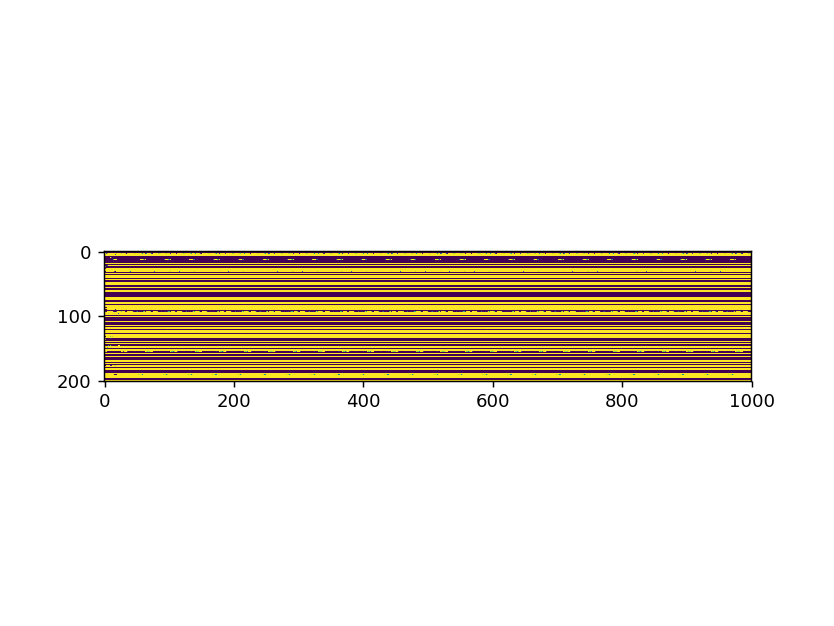

<IPython.core.display.Javascript object>


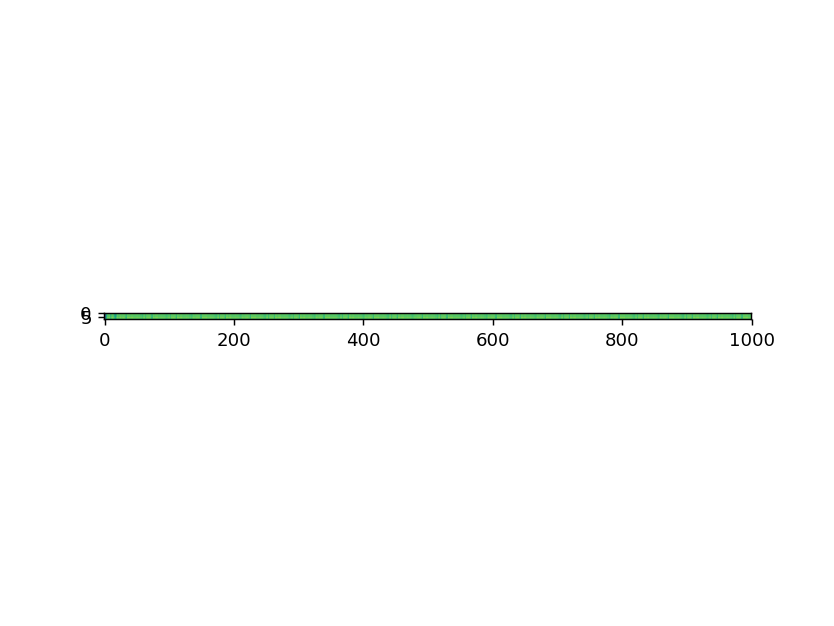

<IPython.core.display.Javascript object>


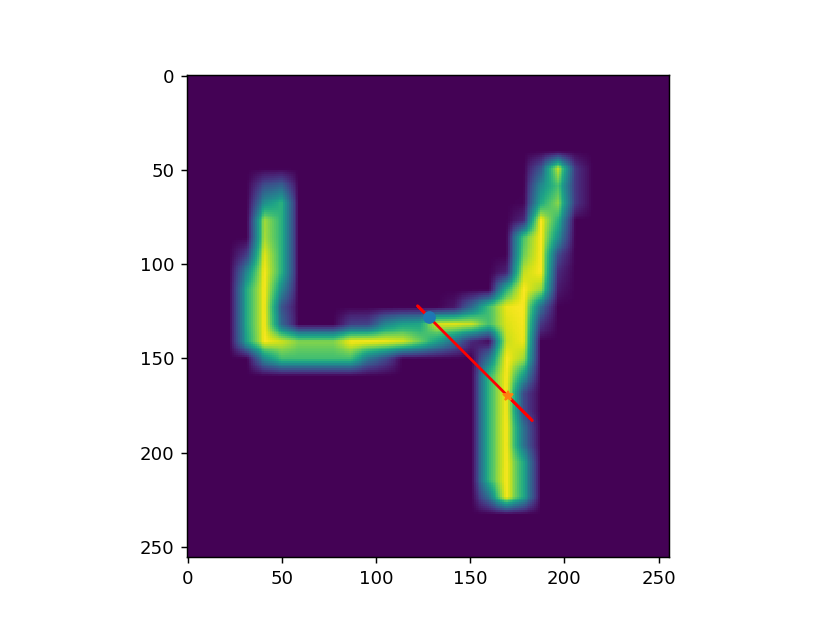

<IPython.core.display.Javascript object>


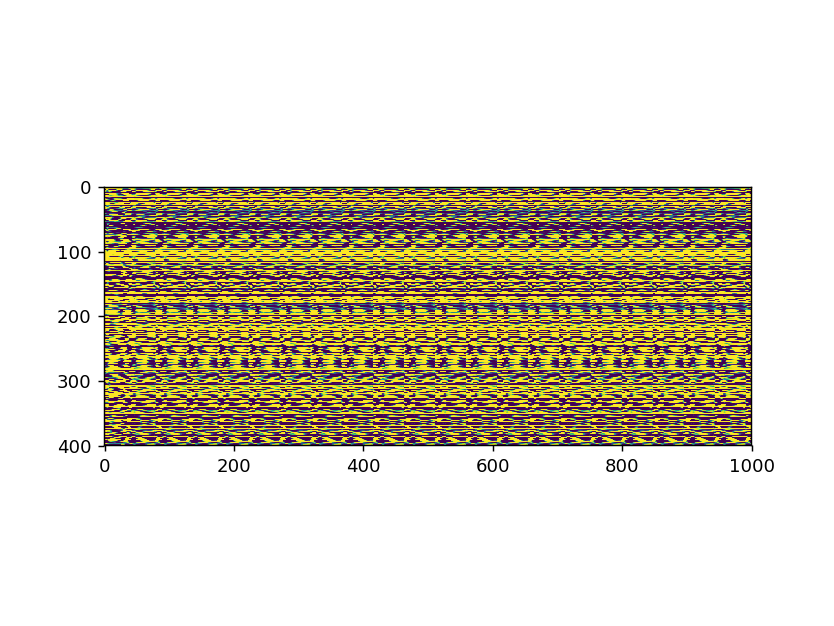

<IPython.core.display.Javascript object>


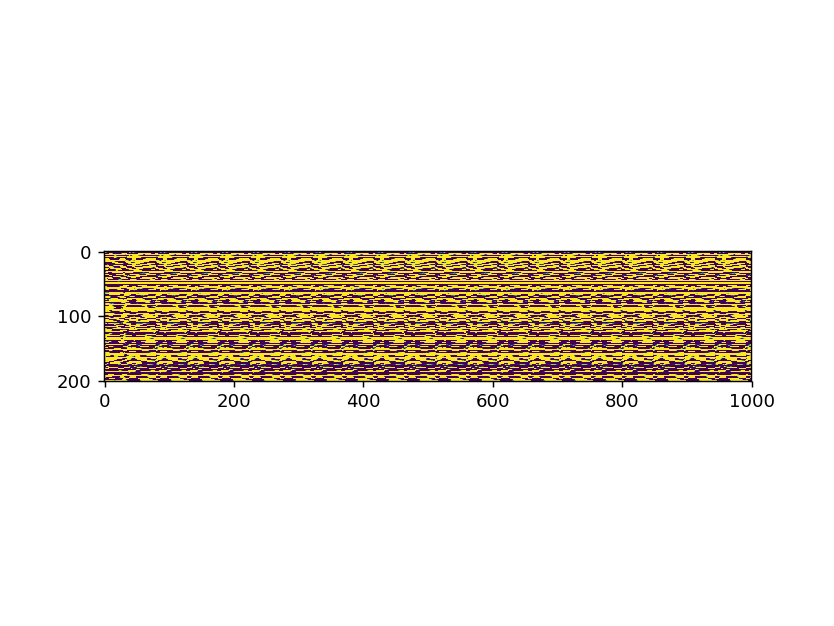

<IPython.core.display.Javascript object>


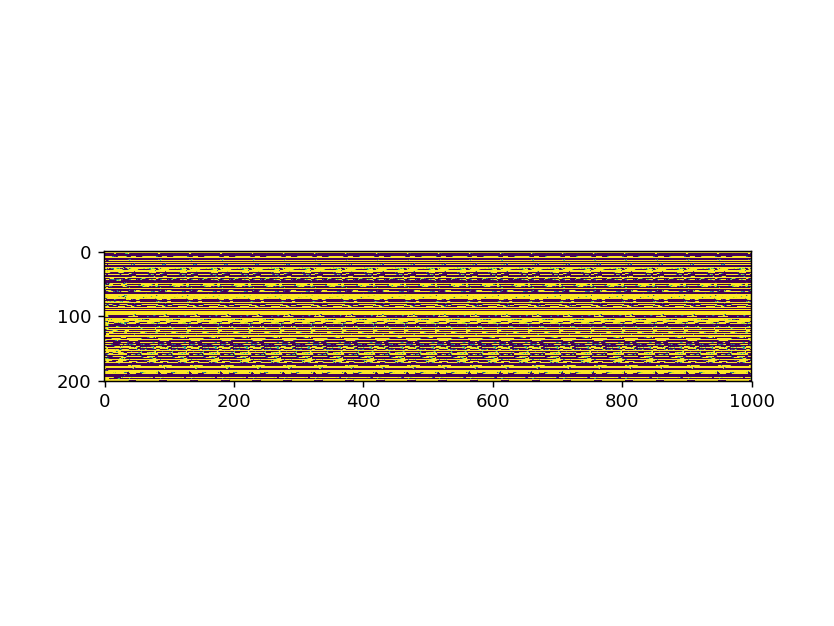

<IPython.core.display.Javascript object>


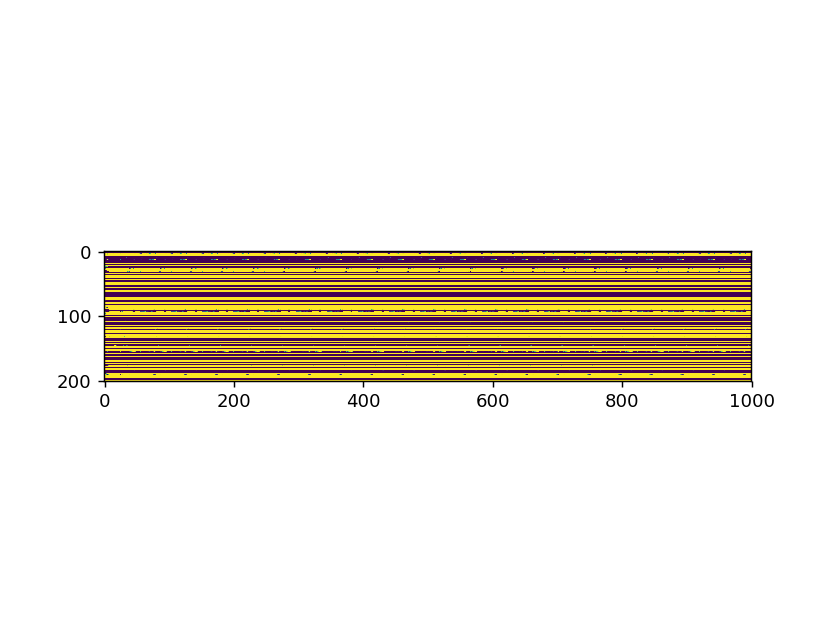

<IPython.core.display.Javascript object>


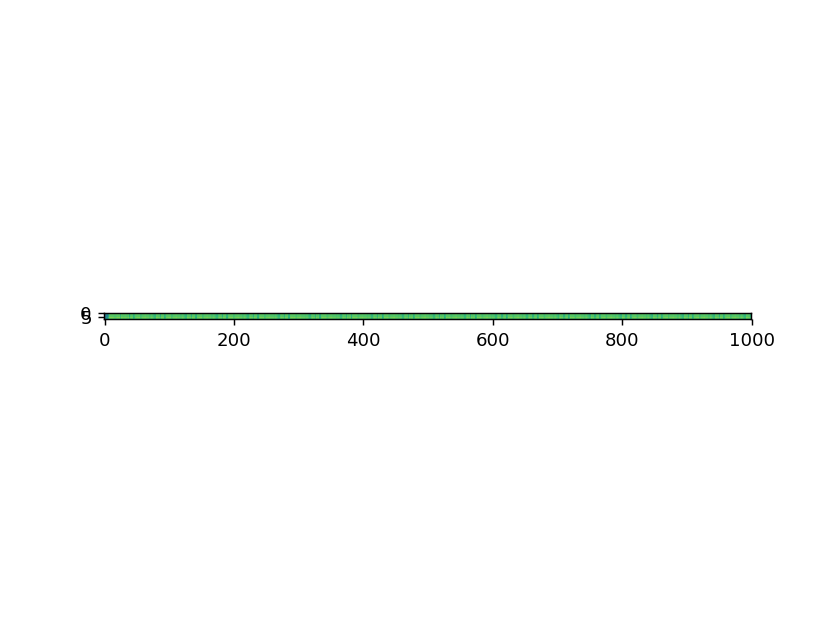

<IPython.core.display.Javascript object>


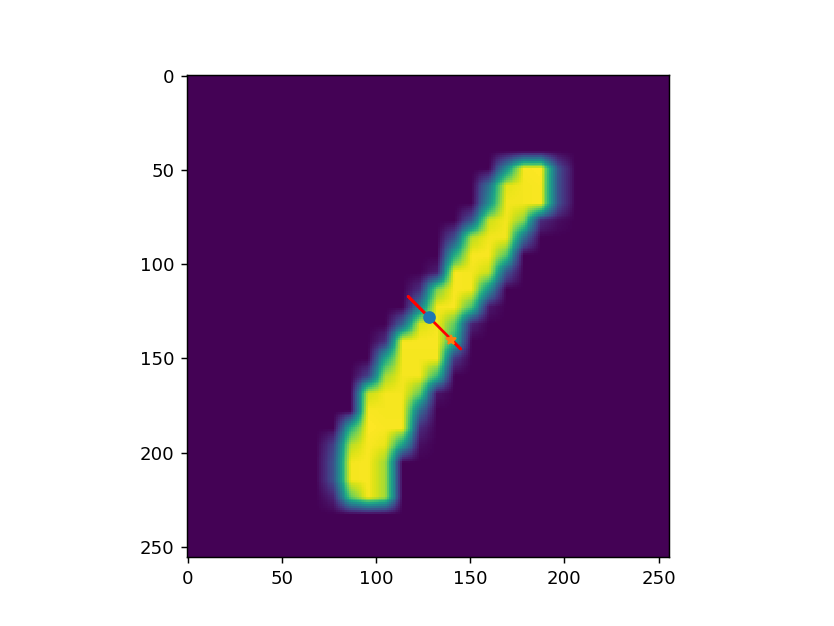

<IPython.core.display.Javascript object>


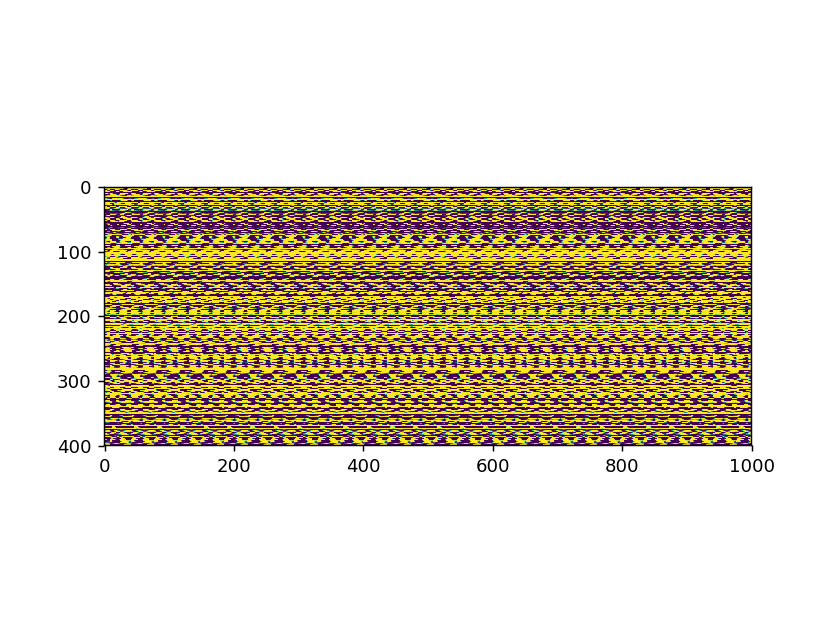

<IPython.core.display.Javascript object>


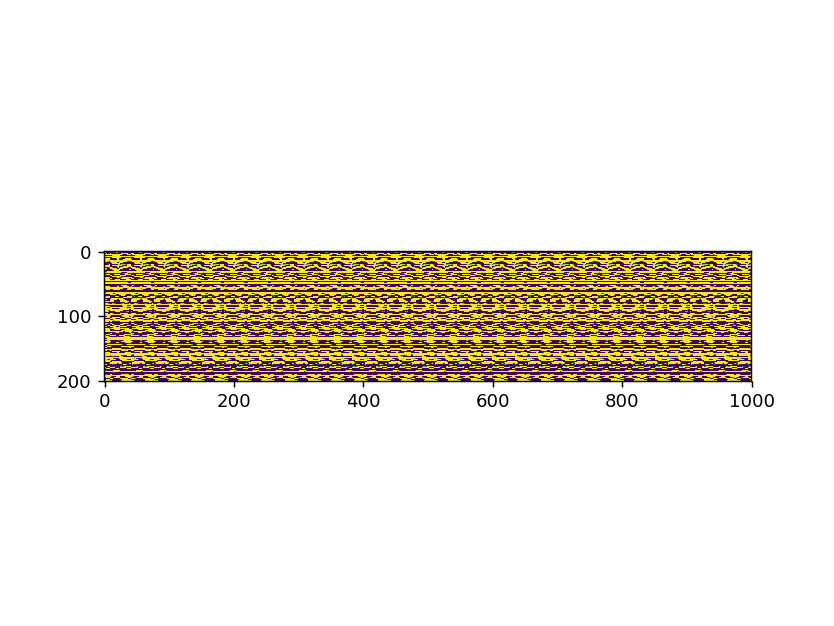

<IPython.core.display.Javascript object>


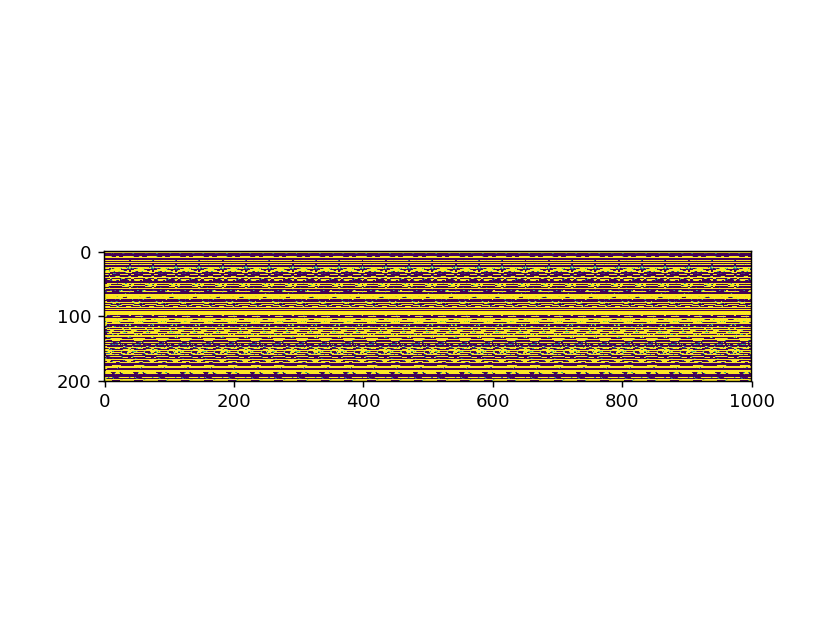

<IPython.core.display.Javascript object>


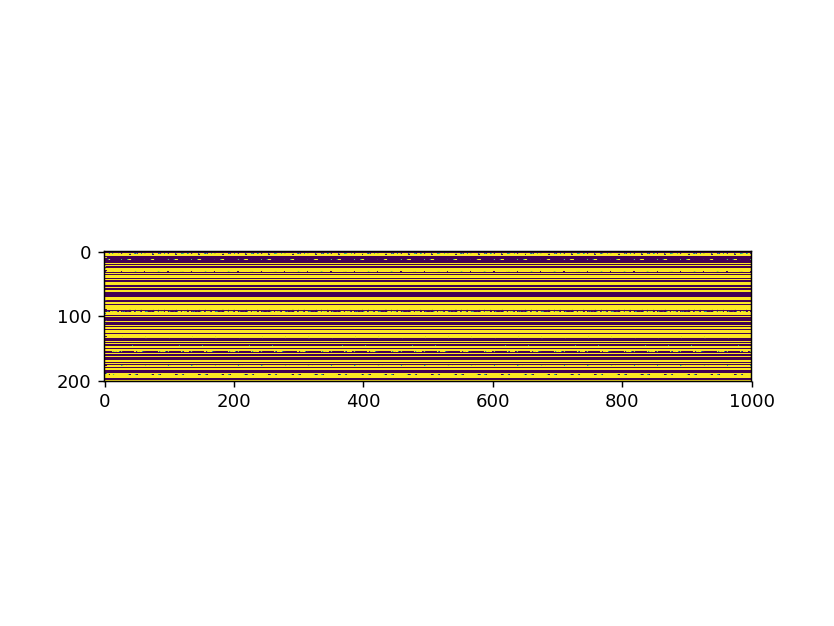

<IPython.core.display.Javascript object>


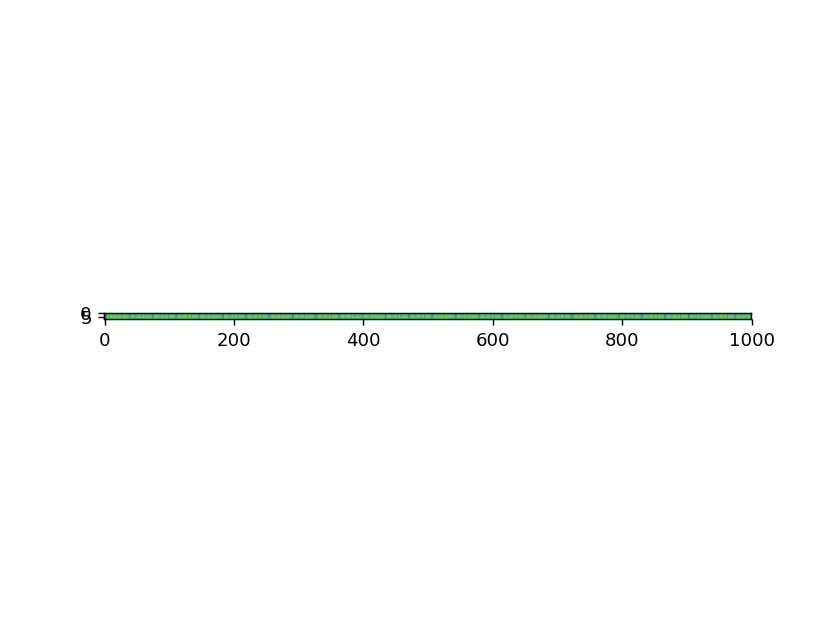

<IPython.core.display.Javascript object>


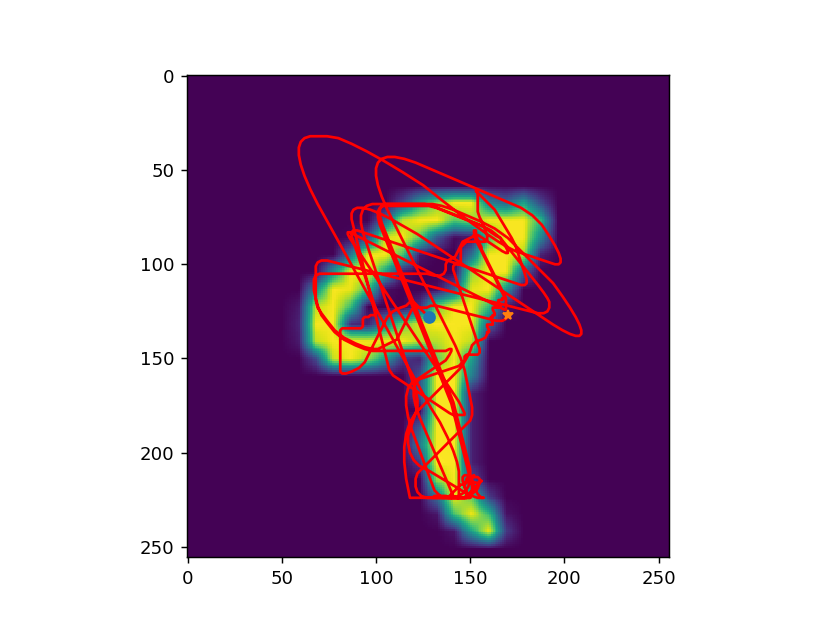

<IPython.core.display.Javascript object>


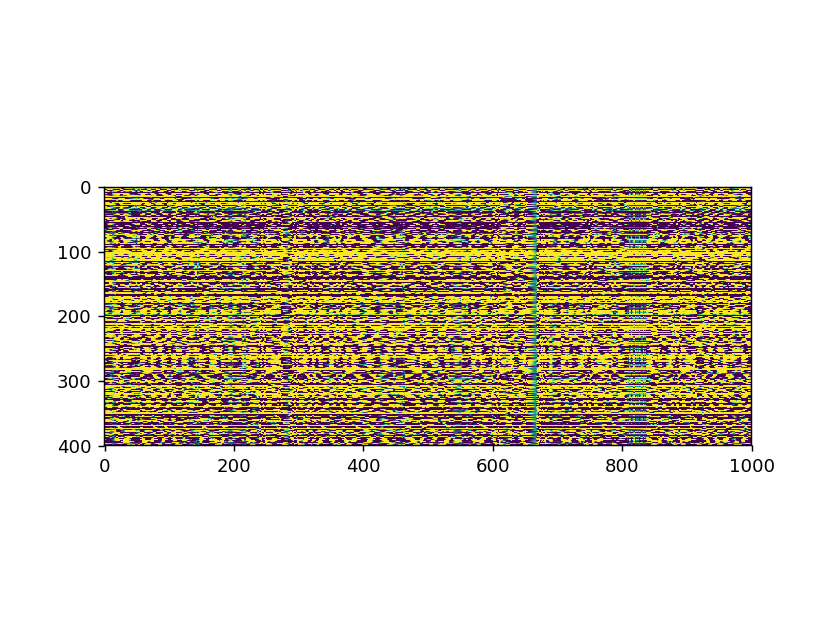

<IPython.core.display.Javascript object>


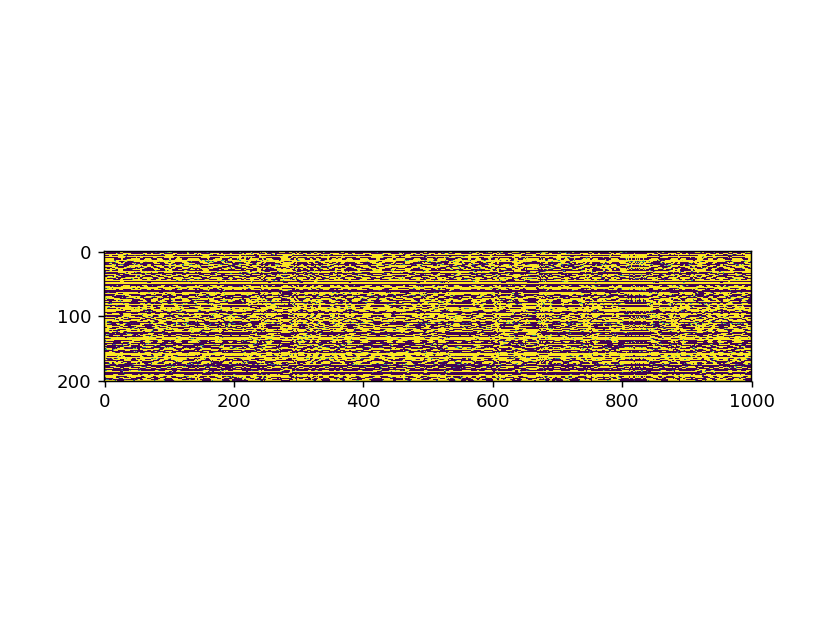

<IPython.core.display.Javascript object>


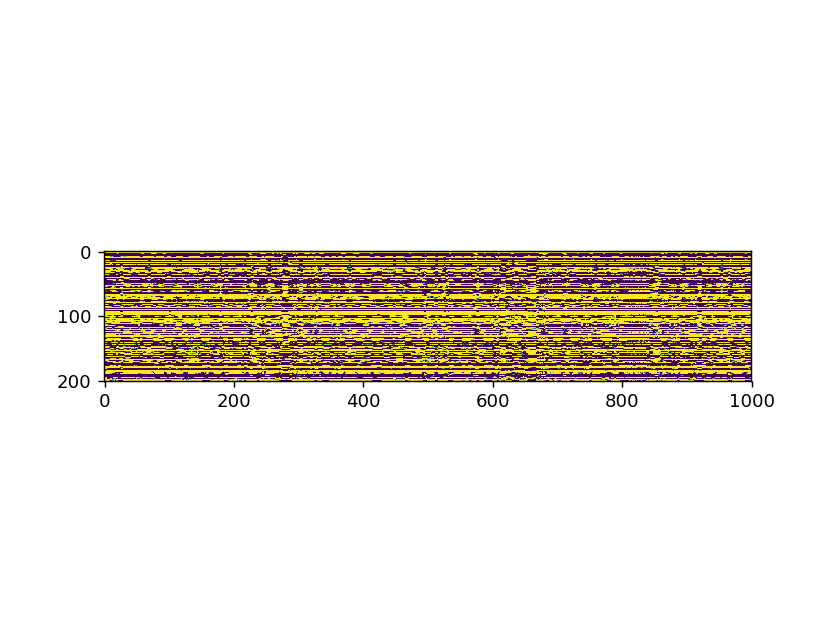

<IPython.core.display.Javascript object>


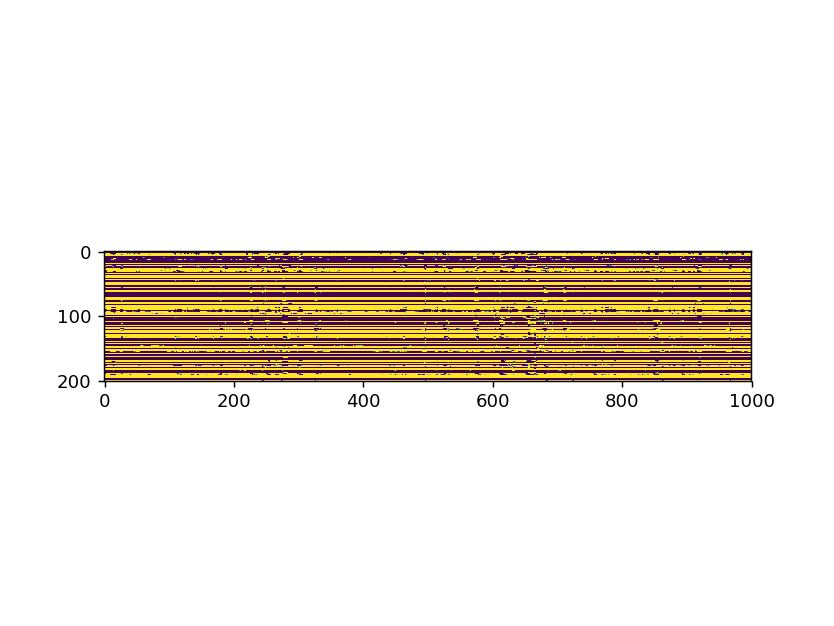

<IPython.core.display.Javascript object>


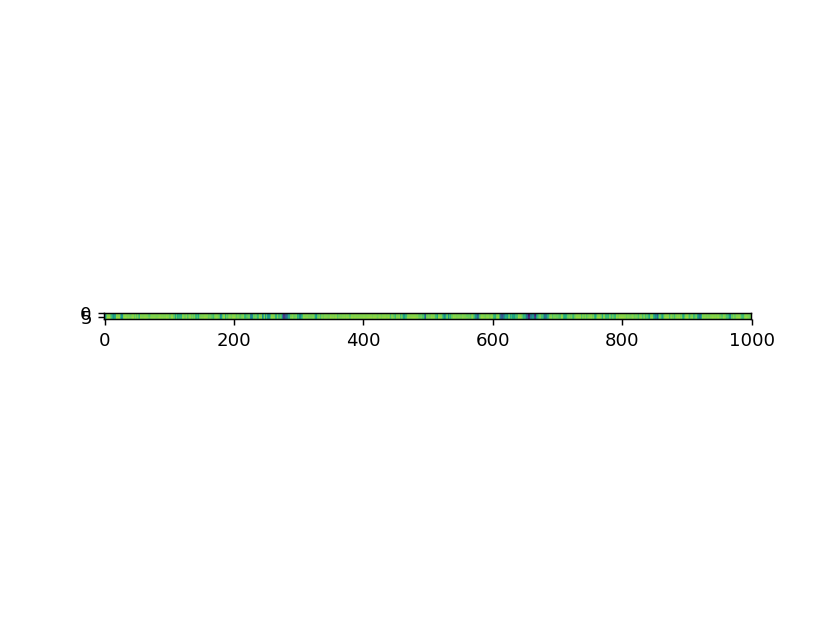

In [32]:
for ii, zz in enumerate(zip(images,recorders)):
# for image,recorder in zip(images,recorders):
    image,recorder = zz[0], zz[1]
    plt.figure()
    plt.imshow(image,vmax=256,vmin=0)
    plt.plot(32+np.array(recorder.records[0]),image.shape[0]-32-np.array(recorder.records[1]),'r-')
    plt.plot(32+np.array(recorder.records[0])[0],image.shape[0]-32-np.array(recorder.records[1])[0],'o')
    plt.plot(32+np.array(recorder.records[0])[-1],image.shape[0]-32-np.array(recorder.records[1])[-1],'*')
    plt.figure()
    plt.imshow(np.array(spike_records[ii][0]).transpose())
    plt.figure()
    plt.imshow(np.array(spike_records[ii][1]).transpose())
    plt.figure()
    plt.imshow(np.array(spike_records[ii][2]).transpose())
    plt.figure()
    plt.imshow(np.array(spike_records[ii][3]).transpose())
    plt.figure()
    plt.imshow(np.array(spike_records[ii][4]).transpose())
# # plt.title('10 syclop trajectories 10,000 timesteps each')

In [11]:
def vanilla_corr(x):
    cc = np.zeros(x.shape)
    for rr in range(x.shape[0]):
        cc[rr,:]=np.correlate(x[rr,:],x[rr,:])
    return np.mean(cc,axis=1)

<IPython.core.display.Javascript object>


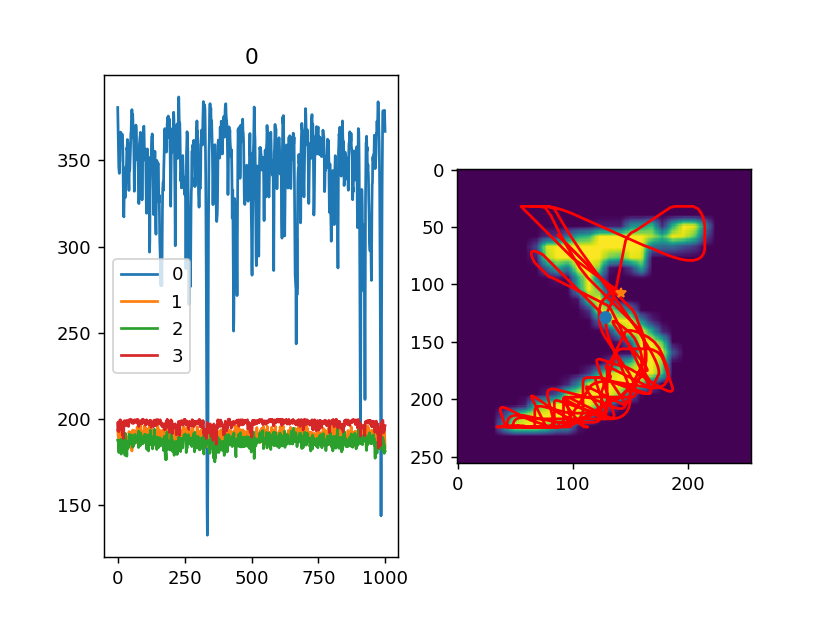

<IPython.core.display.Javascript object>


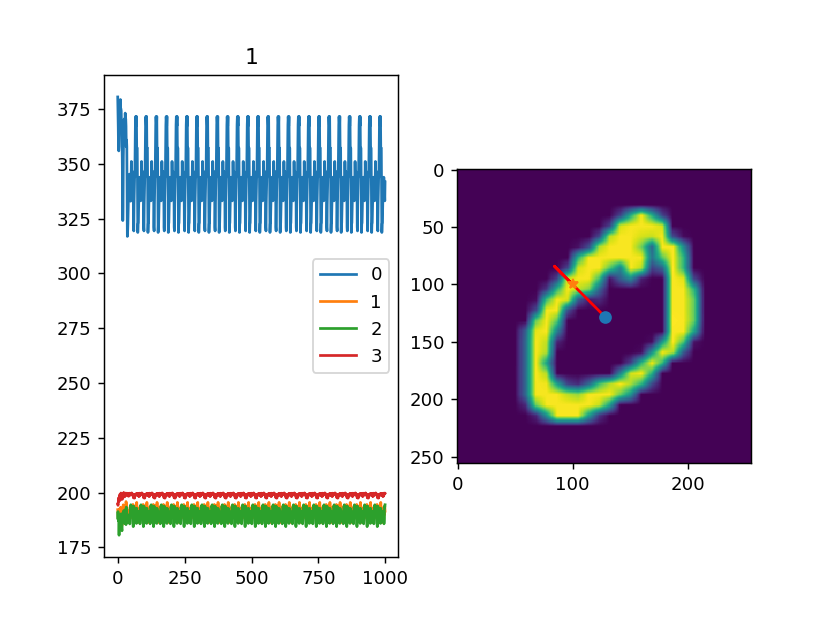

<IPython.core.display.Javascript object>


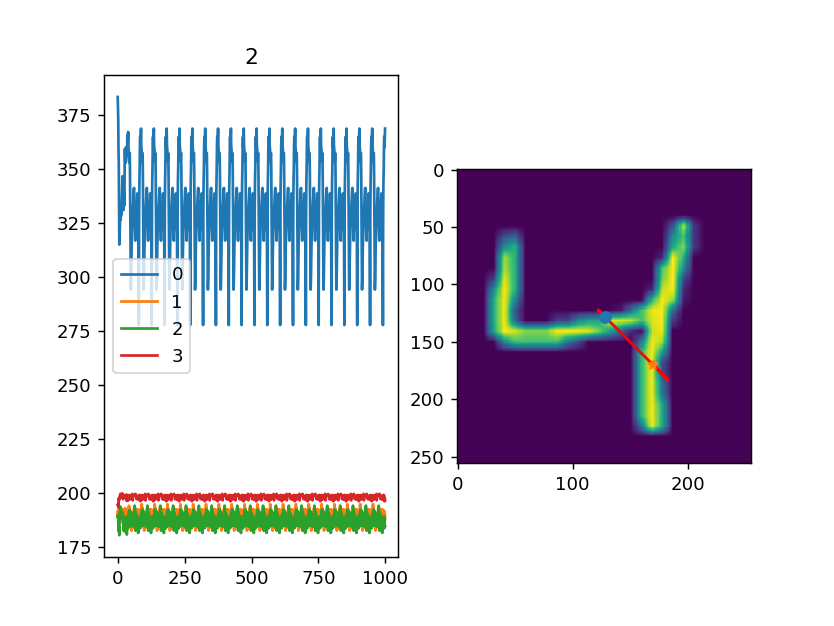

<IPython.core.display.Javascript object>


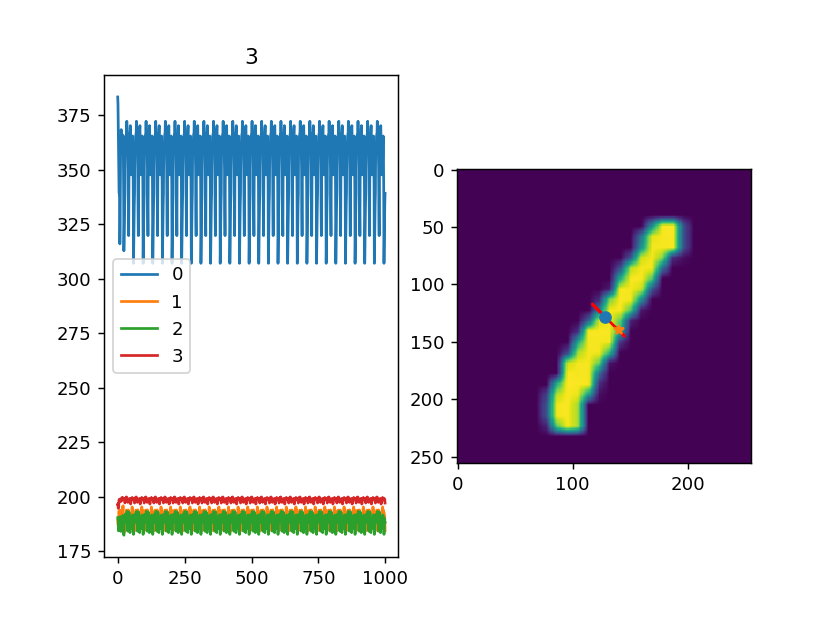

<IPython.core.display.Javascript object>


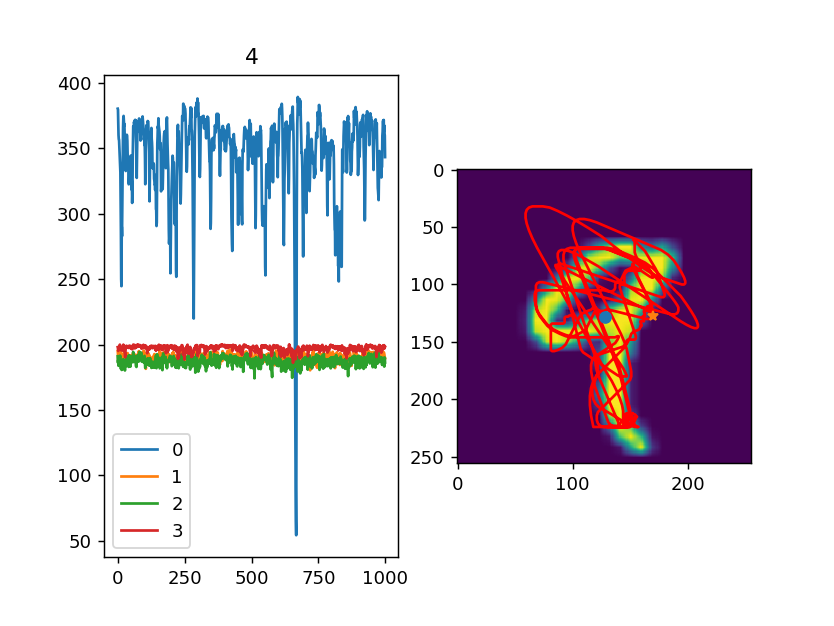

In [33]:
    for ii, zz in enumerate(zip(images,recorders)):
        image,recorder = zz[0], zz[1]
        plt.figure()
        plt.subplot(1,2,1)
        for spk in spike_records[ii][:-1]:
            plt.plot(vanilla_corr(np.array(spk)))
            plt.title(str(ii))
            plt.legend(['0','1','2','3'])
        plt.subplot(1,2,2) 
        plt.imshow(image,vmax=256,vmin=0)
        plt.plot(32+np.array(recorder.records[0]),image.shape[0]-32-np.array(recorder.records[1]),'r-')
        plt.plot(32+np.array(recorder.records[0])[0],image.shape[0]-32-np.array(recorder.records[1])[0],'o')
        plt.plot(32+np.array(recorder.records[0])[-1],image.shape[0]-32-np.array(recorder.records[1])[-1],'*')
#         plt.imshow(vanilla_corr(np.array(spike_records[ii][0]).transpose()))
#         plt.imshow(vanilla_corr(np.array(spike_records[ii][1]).transpose()))
#         plt.imshow(vanilla_corr(np.array(spike_records[ii][2]).transpose()))
#         plt.imshow(vanilla_corr(np.array(spike_records[ii][3]).transpose()))
#         plt.imshow(vanilla_corr(np.array(spike_records[ii][4]).transpose()))

In [ ]:
uu=np.array(spike_records[ii][0])

In [ ]:
uu[4,:].shape